In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn.linear_model as skl_lm

import statsmodels.api as sm
import statsmodels.formula.api as smf

sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=1.2)

/Users/kul/miniconda3/envs/dl/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# 4.1 An Overview of Classification 

In [2]:
Default = pd.read_excel('../data/Default.xlsx')
Default.head()

,default,student,balance,income
1,No,No,729.526495,44361.625074
2,No,Yes,817.180407,12106.134700
3,No,No,1073.549164,31767.138947
4,No,No,529.250605,35704.493935
5,No,No,785.655883,38463.495879


- default

A factor with levels No and Yes indicating whether the customer defaulted on their debt

- student

A factor with levels No and Yes indicating whether the customer is a student

- balance

The average balance that the customer has remaining on their credit card after making their monthly payment

- income

Income of customer

In [3]:
Default.shape

(10000, 4)

In [4]:
Default.describe(include='all')

,default,student,balance,income
count,10000,10000,10000.000000,10000.000000
unique,2,2,NaN,NaN
top,No,No,NaN,NaN
freq,9667,7056,NaN,NaN
mean,NaN,NaN,835.374886,33516.981876
std,NaN,NaN,483.714985,13336.639563
min,NaN,NaN,0.000000,771.967729
25%,NaN,NaN,481.731105,21340.462903
50%,NaN,NaN,823.636973,34552.644802
75%,NaN,NaN,1166.308386,43807.729272


### Figure 4.1

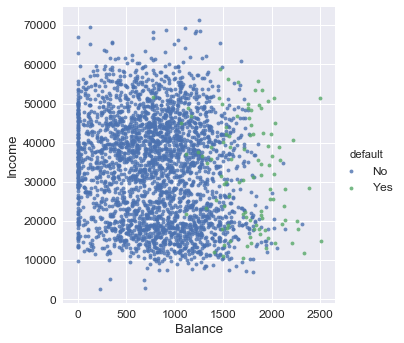

In [5]:
sns.lmplot('balance', 'income',
           data=Default.iloc[:3000],
           fit_reg=False,
           hue="default",  
           scatter_kws={"marker": "D",
                        "s": 15})
plt.xlabel('Balance')
plt.ylabel('Income')
plt.show()

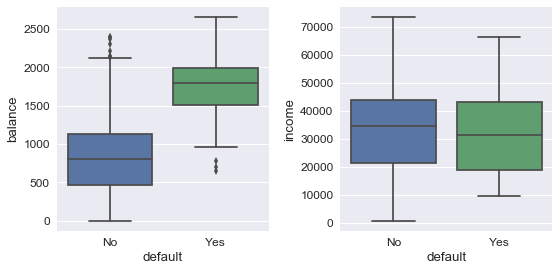

In [6]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))

sns.boxplot('default', 'balance',
            data=Default,
            ax=ax1)
sns.boxplot('default', 'income',
            data=Default,
            ax=ax2)

plt.tight_layout()
plt.show()

## 4.2 Why Not Linear Regression

- We need to encode our qualitative labels to quantitive response variables, when we do so we imply an ordering on the responses. Suppose we are in the case of the 3 possible diagnoses as our responses, **there is no particular reason that the differences among different diagnoses are same**. 
- In general, there is no natural way to convert **multiple (>2)** qualitative responses to quantitative responses.
- For a binary response case, ordinary least square regression does make sense. However, we can **potentially obtain estimates outside the [0, 1] interval**. It's hard to convince ourselves that there exists **negative possibilities**...
- In the real world problem, the **dummy variable approach** cannot be (easily) extended to accommodate qualitative responses with **more than two levels**.

## 4.3 Logistic Regression

Logistic Regression models the probability that **Y belongs to a particular category**.

$$z = \beta_{0} + \beta_{1}X$$

$$p(X) = \frac{e ^ {z}}{1 + e ^ {z}}$$

We use a method called **maximum likelihood** to fit the model.

In [7]:
X_train = Default.balance.values.reshape(-1, 1)
X_test = np.arange(Default.balance.min(), Default.balance.max()).reshape(-1, 1)
y = Default.default.factorize()[0]

clf = skl_lm.LogisticRegression(solver='newton-cg')
clf.fit(X_train, y)
prob = clf.predict_proba(X_test)

### Figure 4.2

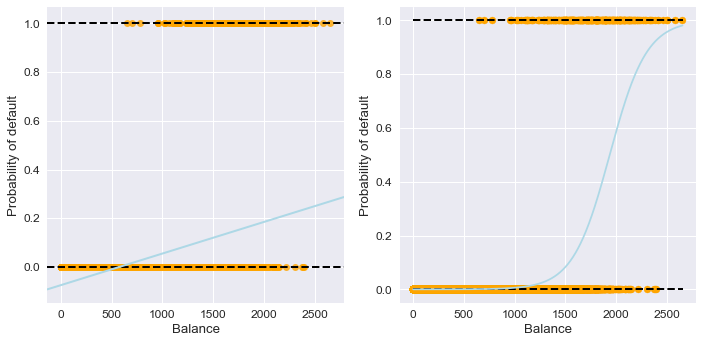

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

sns.regplot(Default.balance, y, order=1, ci=None,
            scatter_kws={'color':'orange'},
            line_kws={'color':'lightblue', 'lw':2}, 
            ax=ax1)

ax2.scatter(X_train, y, color='orange', )
ax2.plot(X_test, prob[:,1], color='lightblue')

for ax in fig.axes:
    ax.hlines(1, 
              xmin=ax.xaxis.get_data_interval()[0],
              xmax=ax.xaxis.get_data_interval()[1], 
              linestyles='dashed', lw=2)
    ax.hlines(0, 
              xmin=ax.xaxis.get_data_interval()[0],
              xmax=ax.xaxis.get_data_interval()[1], 
              linestyles='dashed', lw=2)
    
    ax.set_ylabel('Probability of default')
    ax.set_xlabel('Balance')

plt.tight_layout()
plt.show()

### Table 4.1

In [9]:
X_train = sm.add_constant(Default.balance)
log_reg = smf.Logit(y, X_train).fit()
log_reg.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.079823
         Iterations 10


,coef,std err,z,P>|z|,[0.025,0.975]
const,-10.6513,0.361,-29.491,0.000,-11.359,-9.943
balance,0.0055,0.000,24.952,0.000,0.005,0.006


The *z*-statistic associated with $\beta_{1}$ is equal to $\frac{\hat{\beta}_{1}}{SE(\hat{\beta}_{1})}$, so a large absolute value of *z*-statistic indicates evidence that we can reject the null hypothesis $H_{0}$.

As we can see from the table above, the p-value associated with `balance` is very tiny, therefore, we can reject $H_{0}$, and conclude that there is indeed an association between `balance` probability of `default`.

**Note** - The null hypothesis implies that

$$p(X) = \frac{e^{\beta_{0}}}{1+e^{\beta_{0}}}$$

### Table 4.2

In [10]:
X_train = sm.add_constant(Default.student.factorize()[0])
log_reg = smf.Logit(y, X_train).fit()
log_reg.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.145434
         Iterations 7


,coef,std err,z,P>|z|,[0.025,0.975]
const,-3.5041,0.071,-49.554,0.000,-3.643,-3.366
x1,0.4049,0.115,3.520,0.000,0.179,0.630


`x1` in the table is actually `student[Yes]`.

The coefficient associated with the dummy student variable is positive and the p-value is statistically significant tiny. This indicates that students tend to have higher default probabilities than non-student.

### Table 4.3

In [11]:
X_train = sm.add_constant(Default[['balance', 'income']])
X_train['student[Yes]'] = Default.student.factorize()[0]
log_reg = smf.Logit(y, X_train).fit()
log_reg.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.078577
         Iterations 10


,coef,std err,z,P>|z|,[0.025,0.975]
const,-10.8690,0.492,-22.079,0.000,-11.834,-9.904
balance,0.0057,0.000,24.737,0.000,0.005,0.006
income,3.033e-06,8.2e-06,0.370,0.712,-1.3e-05,1.91e-05
student[Yes],-0.6468,0.236,-2.738,0.006,-1.110,-0.184


Why in **Table 4.3** we see a negative coefficient for `student[Yes]`?

Because the two models illustrate different perspectives.

At this moment, let's say with **a fixed value of** `balance` **and** `income`, a student is less likely to default than a non-student. We can check this from **Figure 4.3**.

In [12]:
Default['default_encoded'] = Default.default.factorize()[0]

# https://github.com/JWarmenhoven/ISLR-python/
# balance and default vectors for students
X_train = Default[Default.student == 'Yes'].balance.values.reshape(Default[Default.student == 'Yes'].balance.size, 1) 
y = Default[Default.student == 'Yes'].default_encoded

# balance and default vectors for non-students
X_train2 = Default[Default.student == 'No'].balance.values.reshape(Default[Default.student == 'No'].balance.size, 1) 
y2 = Default[Default.student == 'No'].default_encoded

# vector with balance values for plotting
X_test = np.arange(Default.balance.min(), Default.balance.max()).reshape(-1,1)

clf = skl_lm.LogisticRegression(solver='newton-cg')
clf2 = skl_lm.LogisticRegression(solver='newton-cg')

clf.fit(X_train, y)
clf2.fit(X_train2, y2)

prob = clf.predict_proba(X_test)
prob2 = clf2.predict_proba(X_test)

Default.groupby(['student', 'default']).size().unstack('default')

default,No,Yes
student,,
No,6850,206
Yes,2817,127


### Figure 4.3

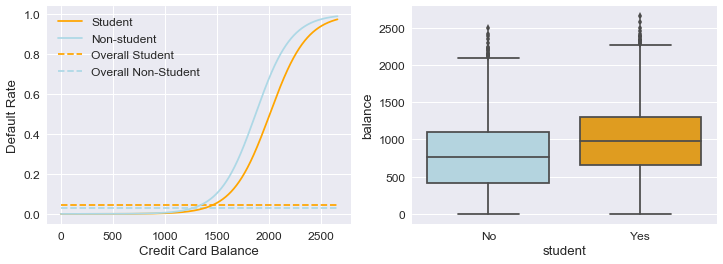

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Left plot
ax1.plot(X_test, prob[:,1], color='orange', label='Student')
ax1.plot(X_test, prob2[:,1], color='lightblue', label='Non-student')
xmin, xmax = ax1.xaxis.get_data_interval()[0], ax1.xaxis.get_data_interval()[1]
ax1.hlines(127 / 2817, colors='orange', label='Overall Student',
           xmin=xmin, xmax=xmax, linestyles='dashed')
ax1.hlines(206 / 6850, colors='lightblue', label='Overall Non-Student',
           xmin=xmin, xmax=xmax, linestyles='dashed')

ax1.set_ylabel('Default Rate')
ax1.set_xlabel('Credit Card Balance')
ax1.legend(loc=2)

# Right plot
sns.boxplot('student', 'balance', data=Default, orient='v', ax=ax2, palette={'No':'lightblue', 'Yes':'orange'});

The phenomenon seen in **Figure 4.3** is known as confounding.

## 4.4 Linear Discriminant Analysis

TODO...